In [ ]:
!git clone "https://github.com/kk-digital/kcg-ml-sd1p4.git"
%cd kcg-ml-sd1p4

In [ ]:
!pip install -r requirements.txt

In [1]:
%cd kcg-ml-sd1p4

/content/kcg-ml-sd1p4


In [ ]:
!python3 ./download_models.py

In [ ]:
!python3 ./process_models.py

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


INFO: NumExpr defaulting to 2 threads.


INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpgm0fieo5


INFO: Created a temporary directory at /tmp/tmpgm0fieo5


INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpgm0fieo5/_remote_module_non_scriptable.py


INFO: Writing /tmp/tmpgm0fieo5/_remote_module_non_scriptable.py


Loading tokenizer and transformer...[DONE]	2,053.90ms
Loading tokenizer and transformer...[DONE]	1,841.33ms
Sample...[DONE]	5,885.45ms
Sample...[DONE]	5,757.96ms
Sample...[DONE]	5,921.29ms
Sample...[DONE]	6,009.26ms
Sample...[DONE]	5,810.46ms
Sample...[DONE]	5,709.54ms
Sample...[DONE]	5,627.54ms
Sample...[DONE]	5,575.98ms
Sample...[DONE]	5,535.77ms
Sample...[DONE]	5,542.47ms
Sample...[DONE]	5,550.66ms
Sample...[DONE]	5,574.45ms
Sample...[DONE]	5,601.23ms
Sample...[DONE]	5,645.35ms
Sample...[DONE]	5,676.07ms
Sample...[DONE]	5,690.61ms
Sample...[DONE]	5,703.85ms
Sample...[DONE]	5,681.54ms
Sample...[DONE]	5,662.57ms
Sample...[DONE]	5,652.24ms
Sample...[DONE]	5,629.03ms
Sample...[DONE]	5,613.10ms
Sample...[DONE]	5,605.02ms
Sample...[DONE]	5,597.16ms
Sample...[DONE]	5,605.14ms
Sample...[DONE]	5,632.52ms
Sample...[DONE]	5,629.58ms
Sample...[DONE]	5,644.07ms
Sample...[DONE]	5,648.90ms
Sample...[DONE]	5,653.15ms
Sample...[DONE]	5,640.33ms
Sample...[DONE]	5,634.38ms


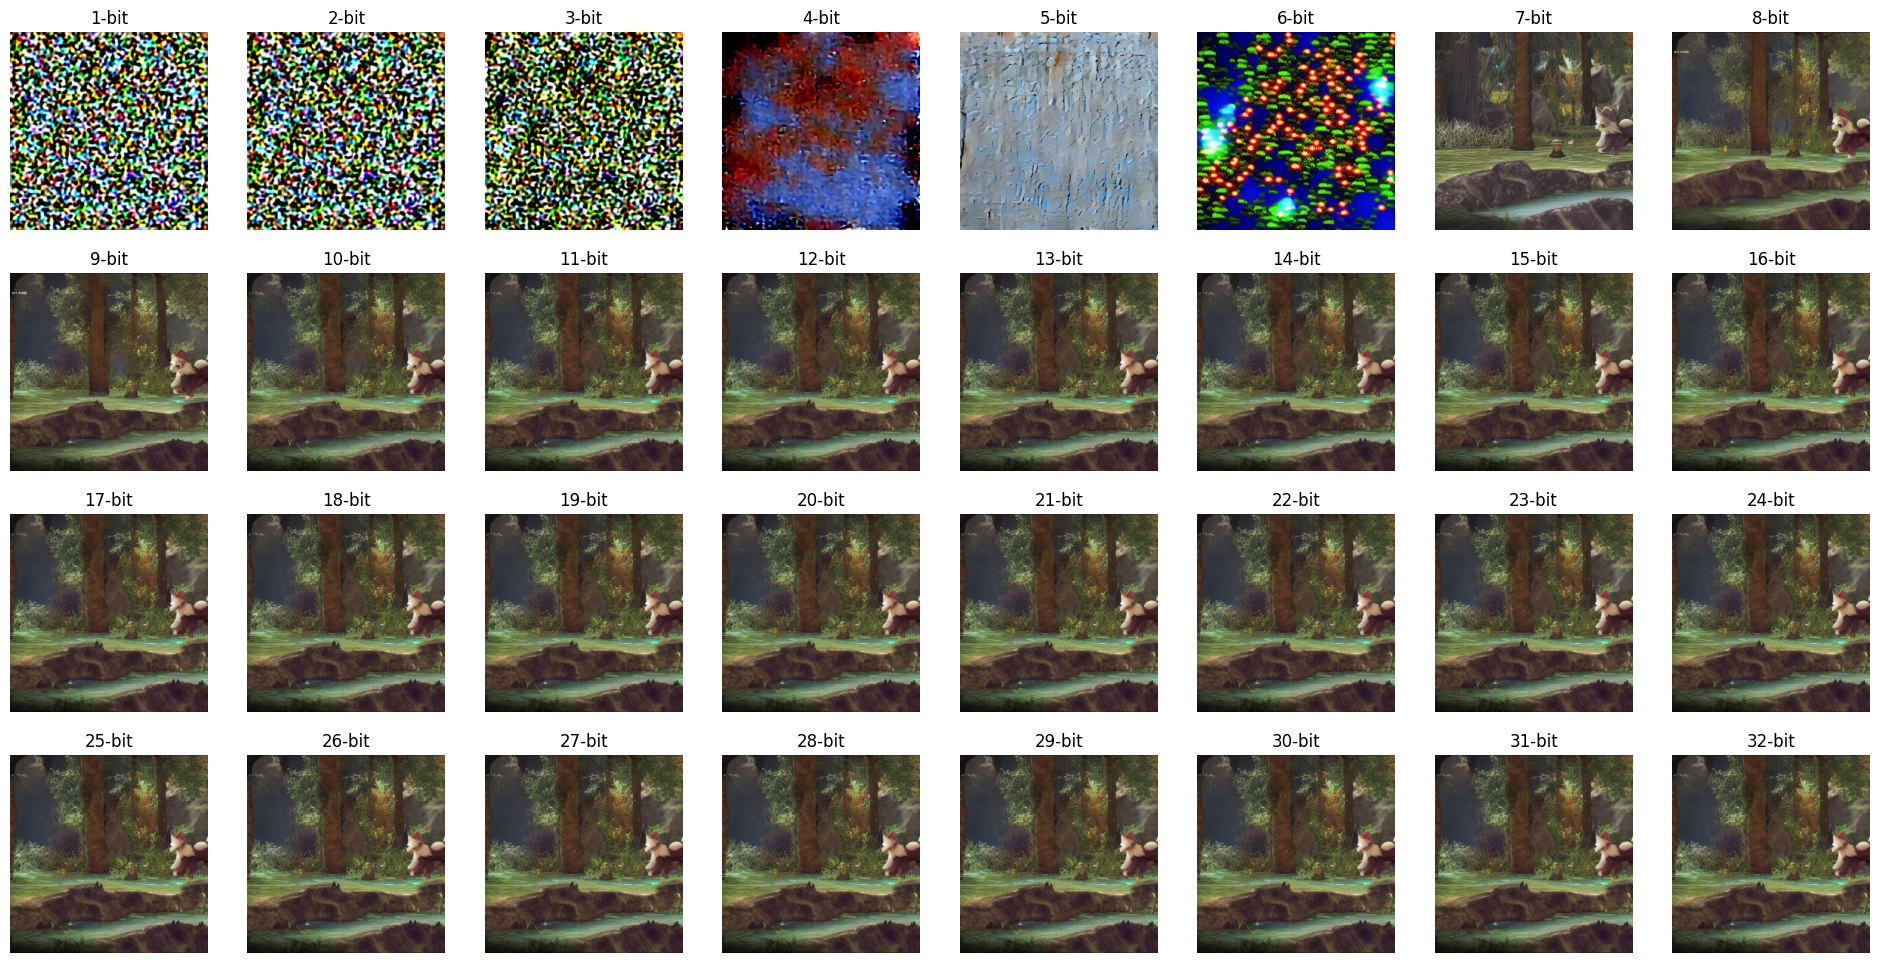

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from configs.model_config import ModelPathConfig
from stable_diffusion import StableDiffusion, SDconfigs
from stable_diffusion.utils_backend import get_device
from stable_diffusion.utils_image import to_pil
import ga

# Initialize configurations
N_STEPS = 20
CFG_STRENGTH = 9

DEVICE = get_device()
config = ModelPathConfig()

# Load Stable Diffusion model
sd = StableDiffusion(device=DEVICE, n_steps=N_STEPS)
sd.quick_initialize().load_autoencoder(config.get_model(SDconfigs.VAE)).load_decoder(config.get_model(SDconfigs.VAE_DECODER))
sd.model.load_unet(config.get_model(SDconfigs.UNET))


def prompt_embedding_vectors(sd, prompt_array):
    embedded_prompts = ga.clip_text_get_prompt_embedding(config, prompts=prompt_array)
    embedded_prompts.to("cpu")
    return embedded_prompts

# Get null prompt and generate prompts
NULL_PROMPT = prompt_embedding_vectors(sd, [""])[0]
prompt_phrase_length = 10
prompts_count = 2
prompts_array = ga.generate_prompts(prompts_count, prompt_phrase_length)

# Get prompt string array
prompts_str_array = [prompt.get_positive_prompt_str() for prompt in prompts_array]

# Get embeddings and move to CPU
embedded_prompts = prompt_embedding_vectors(sd, prompt_array=prompts_str_array)
embedded_prompts_cpu = embedded_prompts.to("cpu").detach().numpy()
del embedded_prompts
torch.cuda.empty_cache()

# Function to quantize the array
def quantize(input_array, bits, min_val, max_val):
    if np.any(input_array > max_val) or np.any(input_array < min_val):
        raise ValueError(f"All elements in input_array must be in the range [{min_val}, {max_val}]")

    n_levels = 2 ** bits
    step = (max_val - min_val) / (n_levels - 1)

    # Shift data to start from 0
    shifted_data = input_array - min_val

    # Quantize
    quantized_data = np.round(shifted_data / step) * step

    # Shift data back to original range
    quantized_data += min_val

    return quantized_data


# Find the minimum and maximum values of the embeddings.
min_val = np.min(embedded_prompts_cpu)
max_val = np.max(embedded_prompts_cpu)


# Initialize output directories and Matplotlib
fig, axs = plt.subplots(4, 8, figsize=(24, 12))  # Subplots for 1 to 32 bits

def generate_image(embedding, bits, ax):
    embedding_quantized = quantize(embedding, bits, min_val, max_val)  # Pass min_val and max_val here
    latent = sd.generate_images_latent_from_embeddings(
        seed=123,
        embedded_prompt=torch.tensor(embedding_quantized, dtype=torch.float32, device=DEVICE),
        null_prompt=NULL_PROMPT,
        uncond_scale=CFG_STRENGTH
    )
    image = sd.get_image_from_latent(latent)
    pil_image = to_pil(image[0])
    filename = os.path.join('output', f'{bits}bit', f'{bits}bit.png')
    pil_image.save(filename)
    ax.imshow(np.array(pil_image))
    ax.set_title(f'{bits}-bit')
    del latent, image
    torch.cuda.empty_cache()

for idx, bits in enumerate(range(1, 33)):  # From 1 to 32 bits
    row, col = divmod(idx, 8)
    os.makedirs(os.path.join('output', f'{bits}bit'), exist_ok=True)
    generate_image(embedded_prompts_cpu[0], bits, axs[row, col])

# Show the grid
for ax in axs.ravel():
    ax.axis('off')
plt.show()